In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
import aprofiles as apro
import numpy as np
import matplotlib.pyplot as plt

path = "data/e-profile/2021/09/08/L2_0-20000-006735_A20210908.nc"
path = "data/e-profile/2021/09/09/L2_0-20000-001492_A20210909.nc"
apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

profiles.range_correction(inplace=True)
profiles.gaussian_filter(sigma=0.0, inplace=True)
profiles.plot(zmin=0, zmax=15000, vmin=1e1, vmax=1e5, log=True, cmap='viridis')

AttributeError: 'numpy.ndarray' object has no attribute 'time'

<xarray.DataArray 'time' (time: 273)>
array(['2021-09-09T00:00:04.000000000', '2021-09-09T00:05:04.000000000',
       '2021-09-09T00:10:04.000000000', ..., '2021-09-09T23:45:06.000000000',
       '2021-09-09T23:50:06.000000000', '2021-09-09T23:55:06.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-09-09T00:00:04 ... 2021-09-09T23:55:06
Attributes:
    long_name:      Time (UTC) of the calibration period
    standard_name:  time

In [388]:
#clouds detection

#make sure some corrections have been done before
if not profiles.data.attenuated_backscatter_0.attrs['range correction']==True:
    print('The range correction has not been applied to backscatter profiles')


#we work on profiles  averaged in time to reduce the noise
rcs = profiles.data.attenuated_backscatter_0
t_avg = 5 * 60 #s
#time resolution in profiles data
dt_s = min(np.diff(profiles.data.time.data)).astype('timedelta64[s]').astype(int)

#number of timestamps to be to averaged
nt_avg = max([1,round(t_avg/dt_s)])
rcs = rcs.rolling(time=nt_avg, min_periods=1, center=True).median()

In [1058]:
from scipy import signal
from scipy.ndimage.filters import uniform_filter1d

def detect_clouds(data, thr_noise=5, thr_clouds = 1.5):
    #data: 1D range corrected signal data 
    #thr_noise = 10 #threshold used in the test to determine if a couple (base,peak) is significant: data[peak(z)] - data[base(z)] >= thr_noise * noise(z)
    #thr_clouds = 1.5 #threshold used to discriminate aerosol from clouds: data[peak(z)] / data[base(z)] >= thr_clouds
    
    #some useful functions:
    def get_indexes(mask):
        #mask: list of Bool
        #returns a list indexes where the mask is True
        return [i for i, x in enumerate(mask) if x]
    
    def make_mask(length, indexes_where_True):
        #length: int: length of the mask
        #indexes_where_true: list
        mask = np.array([False for x in np.ones(length)])
        mask[indexes_where_True] = len(indexes_where_True)*[True]
        return mask

    #0. rolling average
    avg_data = uniform_filter1d(data, size=3)


    #1. first derivative
    ddata_dz = np.diff(data, prepend=0)


    #2. identifies peaks and base by checking the sign changes of the derivative
    sign_changes = np.diff(np.sign(ddata_dz), append=0)
    all_bases = sign_changes==2
    all_peaks = sign_changes==-2
    #get indexes
    i_bases = get_indexes(all_bases)
    i_peaks = get_indexes(all_peaks)


    #3. the signal should start with a base
    if i_bases[0]>i_peaks[0] and i_peaks[0]>=1:
        #set base as the minimum between peak and n gates under
        gates = np.arange(i_peaks[0]-5,i_peaks[0])
        i_base = np.argmin([data[gates[gates>=0]]])
        all_bases[i_base]=True
    #update indexes
    i_bases = get_indexes(all_bases)

    
    #4. keeps significant couples (base,peak)
    # a layer can be considered as a proper layer if the difference of signal between the peak and the base is significant (larger than the noise level)
    # noise evaluation (using a high passing frequency filter)
    b, a = signal.butter(1, 0.3, btype='high')
    noise = signal.filtfilt(b, a, data)
    #rolling average of the noise
    avg_abs_noise = uniform_filter1d(abs_noise, size=100)
    #make sure we have as many peaks as bases
    if len(i_peaks)!=len(i_bases):
        min_len = min([len(i_peaks),len(i_bases)])
        i_peaks = i_peaks[0:min_len]
        i_bases = i_bases[0:min_len]
        

    # data[peak(z)] - data[base(z)] >= thr_noise * noise(z)
    bases, peaks = all_bases, all_peaks
    for i, _ in enumerate(i_bases):
        #data_around_peak = np.mean(data[i_peaks[i]-1:i_peaks[i]+1])
        #data_around_base = np.mean(data[i_bases[i]-1:i_bases[i]+1])
        data_around_peak = avg_data[i_peaks[i]]
        data_around_base = avg_data[i_bases[i]]
        if data_around_peak - data_around_base <= thr_noise * avg_abs_noise[i_bases[i]]:
            bases[i_bases[i]] = False
            peaks[i_peaks[i]] = False
    #get indexes
    i_bases = get_indexes(bases)
    i_peaks = get_indexes(peaks)


    #5. make sure we finish by a peak: remove last base 
    if len(i_bases)>len(i_peaks):
        bases[i_bases[-1]] = False
        i_bases.pop()

    #6. distinction between aerosol and clouds
    for i, _ in enumerate(i_bases):
        data_around_peak = data[i_peaks[i]]
        data_around_base = data[i_bases[i]]
        if abs((data_around_peak - data_around_base) / data_around_base) <= thr_clouds:
            bases[i_bases[i]] = False
            peaks[i_peaks[i]] = False
    #get indexes
    i_bases = get_indexes(bases)
    i_peaks = get_indexes(peaks)
    

    #7. find tops of clouds layers
    tops = np.array([False for x in np.ones(len(data))])
    # conditions: look for bases above i_peaks[i], and data[top[i]] <= data[base[i]]
    for i, _ in enumerate(i_bases):
        mask_value = np.array(data<data[i_bases[i]])
        mask_altitude = np.array([False for x in np.ones(len(data))])
        mask_altitude[i_bases[i]:] = True
        #the top is the first value that corresponds to the intersection of the two masks
        cross_mask = np.logical_and(mask_value, mask_altitude)
        i_cross_mask = get_indexes(cross_mask)
        if len(i_cross_mask)>0:
            if tops[i_cross_mask[0]]:
                #print('top already found. remove current layer')
                bases[i_bases[i]] = False
                peaks[i_peaks[i]] = False    
            else:
                #print('found top at ',i_cross_mask[0], 'for base ',i_bases[i])
                tops[i_cross_mask[0]] = True
        else:
            #print('no top found for base',i_bases[i])
            bases[i_bases[i]] = False
            peaks[i_peaks[i]] = False

    #get indexes
    i_bases = get_indexes(bases)
    i_peaks = get_indexes(peaks)
    i_tops = get_indexes(tops)

    
    #8. merge layers: just focus on bases and tops
    #drop layer if base of next layer below top of current layer top of current layer
    for i in np.arange(len(i_bases)-1):
        if i<len(i_bases)-1 and i_bases[i+1]<=i_tops[i]:
            i_bases.remove(i_bases[i+1])
            i_tops.remove(i_tops[i])

    
    #9. rebuild base and top masks
    bases = make_mask(len(data), i_bases)
    peaks = make_mask(len(data), [])
    tops = make_mask(len(data), i_tops)
    #find peaks between bases and tops
    for i in np.arange(len(i_bases)):
        peaks[i_bases[i]+np.argmax(data[i_bases[i]:i_tops[i]])] = True
    #get new indexes
    i_peaks = get_indexes(peaks)
    
    """
    #some plotting
    fig, axs = plt.subplots(1,2,figsize=(10,10))
    
    ymin, ymax = 000, 15000
    altitude_agl = profiles.data.altitude.data - profiles.data.station_altitude.data
    
    #signal on the left
    axs[0].plot(data, altitude_agl, 'b', label='rcs')
    axs[0].plot(avg_data, altitude_agl, 'c', label='rcs')
    axs[0].plot(avg_abs_noise,altitude_agl,':b', label='noise level')
    axs[0].plot(avg_abs_noise*thr_noise,altitude_agl,':b', label='noise level * {}'.format(thr_noise))
    axs[0].plot(data[bases], altitude_agl[bases], '<g', label='bases')
    axs[0].plot(data[peaks], altitude_agl[peaks], '>r', label='peaks')
    axs[0].plot(data[tops], altitude_agl[tops], '^k', label='tops')
    
    #set axis
    axs[0].set_ylim([ymin, ymax])
    #axs[0].set_xlim([-20000,20000])
    axs[0].legend()

    #derivative on the right
    axs[1].plot(ddata_dz, altitude_agl, 'b', label='first derivative')
    axs[1].plot(ddata_dz[bases], altitude_agl[bases], '<g', label='bases')
    axs[1].plot(ddata_dz[peaks], altitude_agl[peaks], '>r', label='peaks')
    
    axs[1].set_ylim([ymin, ymax])
    axs[1].legend()
    #set title
    fig.suptitle(t,weight='bold')
    """

    return {
        'bases': bases,
        'peaks': peaks,
        'tops': tops,
    }


In [1081]:
clouds_bases, clouds_peaks, clouds_tops = [], [], []
for i, t in enumerate(rcs.time.data):
#for i, t in enumerate([0]):
    data = rcs.data[i,:]
    clouds = detect_clouds(data, thr_noise=5, thr_clouds = 1.5)
    
    #store info in 2D array
    clouds_bases.append(clouds['bases'])
    clouds_peaks.append(clouds['peaks'])
    clouds_tops.append(clouds['tops'])
    
#creates dataarrays
bases_da = xr.DataArray(
    data=clouds_bases,
    dims=["time", "altitude"],
    coords=dict(
        time=profiles.data.time.data,
        altitude=profiles.data.altitude.data,
    ),
    attrs=dict(
        description="Mask - Base height of clouds",
        units="bool",
    )
)
peaks_da = xr.DataArray(
    data=clouds_peaks,
    dims=["time", "altitude"],
    coords=dict(
        time=profiles.data.time.data,
        altitude=profiles.data.altitude.data,
    ),
    attrs=dict(
        description="Mask - Peak height of clouds",
        units="bool",
    )
)
tops_da = xr.DataArray(
    data=clouds_tops,
    dims=["time", "altitude"],
    coords=dict(
        time=profiles.data.time.data,
        altitude=profiles.data.altitude.data,
    ),
    attrs=dict(
        description="Mask - Top height of clouds",
        units="bool",
    )
)

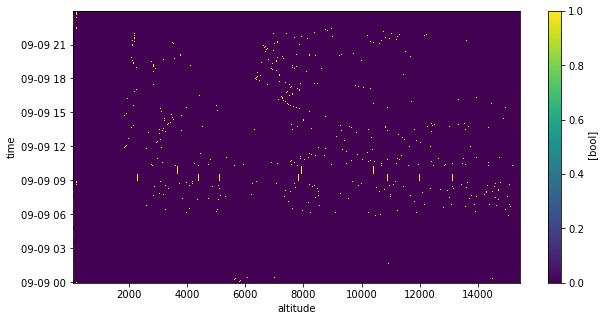

In [1082]:
bases_da.plot()

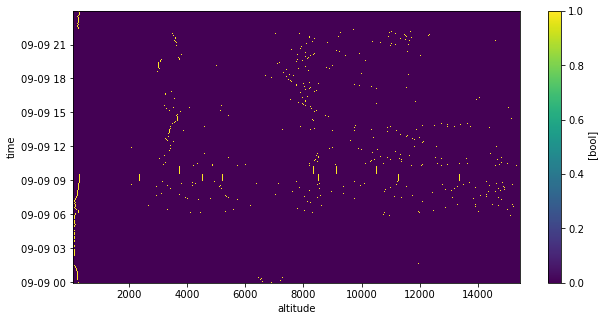

In [1085]:
peaks_da.plot()

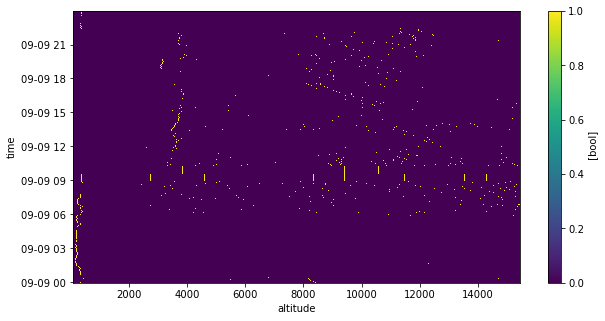

In [1084]:
tops_da.plot()

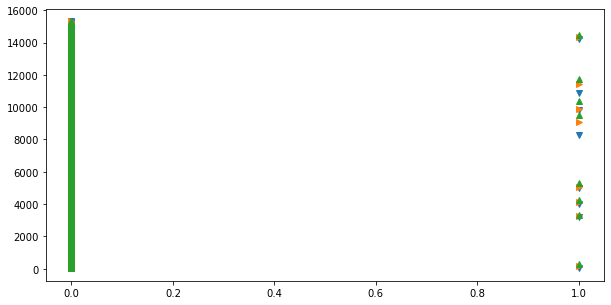

In [1057]:
plt.plot(bases,altitude_agl,'v')
plt.plot(peaks,altitude_agl,'>')
plt.plot(tops,altitude_agl,'^')


found top at  9 for base  1
found top at  111 for base  106
found top at  141 for base  133
found top at  177 for base  166
found top at  317 for base  276
found top at  345 for base  327
found top at  392 for base  362
top already found. remove current layer
found top at  481 for base  474
no top found for base 494
no top found for base 503
8 8 8


Text(0.5, 0.98, '2021-09-09T08:35:05.000000000')

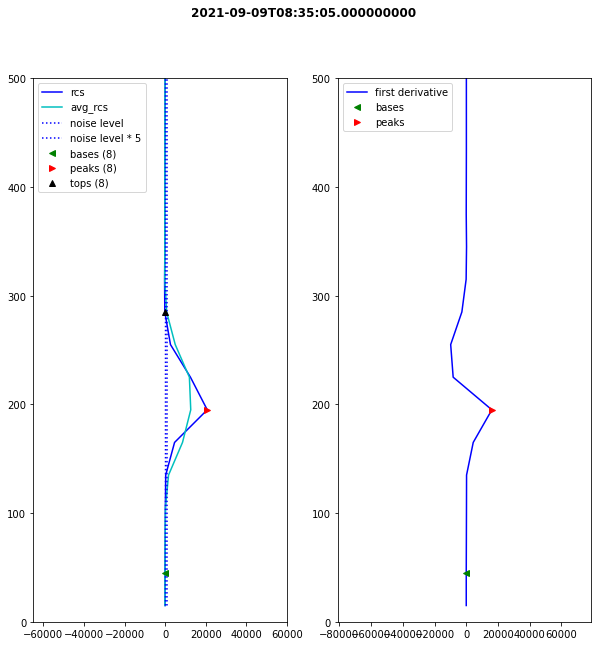

In [1049]:
#data: 1D range corrected signal data 
#thr_noise = 10 #threshold used in the test to determine if a couple (base,peak) is significant: data[peak(z)] - data[base(z)] >= thr_noise * noise(z)
#thr_clouds = 1.5 #threshold used to discriminate aerosol from clouds: data[peak(z)] / data[base(z)] >= thr_clouds

thr_noise = 5
thr_clouds = 1.5

#some useful functions:
def get_indexes(mask):
    #get indexes where mask is True
    return [i for i, x in enumerate(mask) if x]
def make_mask(length, indexes_where_True):
    #length: int: length of the mask
    #indexes_where_true: list
    mask = np.array([False for x in np.ones(length)])
    mask[indexes_where_True] = len(indexes_where_True)*[True]
    return mask

#0. rolling average
avg_data = uniform_filter1d(data, size=3)


#1. first derivative
ddata_dz = np.diff(data, prepend=0)


#2. identifies peaks and base by checking the sign changes of the derivative
sign_changes = np.diff(np.sign(ddata_dz), append=0)
all_bases = sign_changes==2
all_peaks = sign_changes==-2
#get indexes
i_bases = get_indexes(all_bases)
i_peaks = get_indexes(all_peaks)


#3. the signal should start with a base
if i_bases[0]>i_peaks[0] and i_peaks[0]>=1:
    #set base as the minimum between peak and n gates under
    gates = np.arange(i_peaks[0]-5,i_peaks[0])
    i_base = np.argmin([data[gates[gates>=0]]])
    all_bases[i_base]=True
#update indexes
i_bases = get_indexes(all_bases)


#4. keeps significant couples (base,peak)
# a layer can be considered as a proper layer if the difference of signal between the peak and the base is significant (larger than the noise level)
# noise evaluation (using a high passing frequency filter)
b, a = signal.butter(1, 0.3, btype='high')
noise = signal.filtfilt(b, a, data)
#rolling average of the noise
avg_abs_noise = uniform_filter1d(abs_noise, size=100)
#make sure we have as many peaks as bases
if len(i_peaks)!=len(i_bases):
    min_len = min([len(i_peaks),len(i_bases)])
    i_peaks = i_peaks[0:min_len]
    i_bases = i_bases[0:min_len]
    

# data[peak(z)] - data[base(z)] >= thr_noise * noise(z)
bases, peaks = all_bases, all_peaks
for i, _ in enumerate(i_bases):
    #data_around_peak = np.mean(data[i_peaks[i]-1:i_peaks[i]+1])
    #data_around_base = np.mean(data[i_bases[i]-1:i_bases[i]+1])
    data_around_peak = avg_data[i_peaks[i]]
    data_around_base = avg_data[i_bases[i]]
    if data_around_peak - data_around_base <= thr_noise * avg_abs_noise[i_bases[i]]:
        bases[i_bases[i]] = False
        peaks[i_peaks[i]] = False
#get indexes
i_bases = get_indexes(bases)
i_peaks = get_indexes(peaks)


#5. make sure we finish by a peak: remove last base 
if len(i_bases)>len(i_peaks):
    bases[i_bases[-1]] = False
    i_bases.pop()


#6. distinction between aerosol and clouds
for i, _ in enumerate(i_bases):
    data_around_peak = data[i_peaks[i]]
    data_around_base = data[i_bases[i]]
    if abs((data_around_peak - data_around_base) / data_around_base) <= thr_clouds:
        bases[i_bases[i]] = False
        peaks[i_peaks[i]] = False
#get indexes
i_bases = get_indexes(bases)
i_peaks = get_indexes(peaks)



#7. find tops of clouds layers
tops = np.array([False for x in np.ones(len(data))])
# conditions: look for bases above i_peaks[i], and data[top[i]] <= data[base[i]]
for i, _ in enumerate(i_bases):
    mask_value = np.array(data<data[i_bases[i]])
    mask_altitude = np.array([False for x in np.ones(len(data))])
    mask_altitude[i_bases[i]:] = True
    #the top is the first value that corresponds to the intersection of the two masks
    cross_mask = np.logical_and(mask_value, mask_altitude)
    i_cross_mask = get_indexes(cross_mask)
    if len(i_cross_mask)>0:
        if tops[i_cross_mask[0]]:
            print('top already found. remove current layer')
            bases[i_bases[i]] = False
            peaks[i_peaks[i]] = False    
        else:
            print('found top at ',i_cross_mask[0], 'for base ',i_bases[i])
            tops[i_cross_mask[0]] = True
    else:
        print('no top found for base',i_bases[i])
        bases[i_bases[i]] = False
        peaks[i_peaks[i]] = False
        
print(len(bases[bases]),len(peaks[peaks]),len(tops[tops]))


#get indexes
i_bases = get_indexes(bases)
i_peaks = get_indexes(peaks)
i_tops = get_indexes(tops)


#8. merge layers: just focus on bases and tops
#drop layer if base of next layer below top of current layer top of current layer
for i in np.arange(len(i_bases)-1):
    if i<len(i_bases)-1 and i_bases[i+1]<=i_tops[i]:
        i_bases.remove(i_bases[i+1])
        i_tops.remove(i_tops[i])

#rebuild base and top masks
bases = make_mask(len(data), i_bases)
peaks = make_mask(len(data), [])
tops = make_mask(len(data), i_tops)
#find peaks between bases and tops
for i in np.arange(len(i_bases)):
    peaks[i_bases[i]+np.argmax(data[i_bases[i]:i_tops[i]])] = True
#get new indexes
i_peaks = get_indexes(peaks)


#some plotting
fig, axs = plt.subplots(1,2,figsize=(10,10))

ymin, ymax = 000, 500
altitude_agl = profiles.data.altitude.data - profiles.data.station_altitude.data

#signal on the left
axs[0].plot(data, altitude_agl, 'b', label='rcs')
axs[0].plot(avg_data, altitude_agl, 'c', label='avg_rcs')

axs[0].plot(avg_abs_noise,altitude_agl,':b', label='noise level')
axs[0].plot(avg_abs_noise*thr_noise,altitude_agl,':b', label='noise level * {}'.format(thr_noise))
axs[0].plot(data[bases], altitude_agl[bases], '<g', label='bases ({})'.format(len(bases[bases==True])))
axs[0].plot(data[peaks], altitude_agl[peaks], '>r', label='peaks ({})'.format(len(peaks[peaks==True])))
axs[0].plot(data[tops], altitude_agl[tops], '^k', label='tops ({})'.format(len(tops[tops==True])))

#set axis
axs[0].set_ylim([ymin, ymax])
#axs[0].set_xlim([-20000,20000])
axs[0].legend()

#derivative on the right
axs[1].plot(ddata_dz, altitude_agl, 'b', label='first derivative')
axs[1].plot(ddata_dz[bases], altitude_agl[bases], '<g', label='bases')
axs[1].plot(ddata_dz[peaks], altitude_agl[peaks], '>r', label='peaks')

axs[1].set_ylim([ymin, ymax])
axs[1].legend()
#set title
fig.suptitle(t,weight='bold')

In [1045]:
for i, _ in enumerate(i_bases):
    mask_value = np.array(data<data[i_bases[i]])
    mask_altitude = np.array([False for x in np.ones(len(data))])
    mask_altitude[i_bases[i]:] = True
    #the top is the first value that corresponds to the intersection of the two masks
    cross_mask = np.logical_and(mask_value, mask_altitude)
    i_cross_mask = get_indexes(cross_mask)
    if len(i_cross_mask)>0:
        print('found top at ',i_cross_mask[0], 'for base ',i_bases[i])
    else:
        print('no top found for base',i_bases[i])

found top at  9 for base  1
found top at  111 for base  106
found top at  141 for base  133
found top at  177 for base  166
found top at  317 for base  276
found top at  345 for base  327
found top at  392 for base  362
found top at  392 for base  379
found top at  481 for base  474
no top found for base 494
no top found for base 503


In [1042]:
mask_value

array([[False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False,  True,  True,  True, False,
         True,  True,  True, False,  True, False, False,  True, False,
         True, False,  True,  True,  True,  True, False,  True, False,
         True,  True,  True,  True, False,  True, False, False,  True,
         True,  True, False,  True, False, False,  True,  True, False,
        False, False, False,  True, False,  True, False,  True,  True,
        False, False,  True,  True, False,  True,  True,  True,  True,
      

In [1023]:
np.shape(data)

(511,)

In [1008]:
tops = np.array([False for x in np.ones(len(data))])
# conditions: look for bases above i_peaks[i], and data[top[i]] <= data[base[i]]
for j, _ in enumerate(i_bases):
    for i in np.arange(i_peaks[j],len(data)):
        mask = data<=data[i_bases[j]]
        #if at least one value is true, sets
        print('base at ',i_bases[j])
        if len(mask[mask])>0:
            print('top found at ',i)
            true_indexes_above_base = [i for i, x in enumerate(mask) if i>i_bases[j]]
            #if already top, remove base and peak of current layer
            if tops[true_indexes_above_base[0]]:
                print('delete')
                bases[i_bases[j]] = False
                peaks[i_peaks[j]] = False
            tops[true_indexes_above_base[0]] = True
            break
        else:
            print('no top found for base at ',i)
            #else, remove base and peak
            bases[i_bases[j]] = False
            peaks[i_peaks[j]] = False

base at  1
top found at  6
base at  106
top found at  108
base at  133
top found at  137
base at  166
top found at  169
base at  276
top found at  278
base at  327
top found at  329
base at  362
top found at  364
base at  379
top found at  381
base at  474
top found at  477
base at  494
top found at  496
base at  503
top found at  507


In [1009]:
print(len(bases[bases]),len(peaks[peaks]),len(tops[tops]))

11 11 11


In [979]:
tops[tops]

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [980]:
peaks[peaks]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [1002]:
tops = np.array([False for x in np.ones(len(data))])

j = 0
for i in np.arange(i_peaks[j],len(data)):
    mask = data<=data[i_bases[j]]
    #if at least one value is true, sets
    print('base at ',i_bases[j])
    if len(mask[mask])>0:
        print('top found at ',i)
        #true_indexes = np.array([i if x>i_bases[j] for i, x in enumerate(mask)])
        #true_indexes_above_base = true_indexes[true_indexes>i_bases[j]]
        true_indexes_above_base = [i for i, x in enumerate(mask) if i>i_bases[j]]
        #if already top, remove base and peak of current layer
        if tops[true_indexes_above_base[0]]:
            print('delete')
            bases[i_bases[j]] = False
            peaks[i_peaks[j]] = False
        tops[true_indexes_above_base[0]] = True
        break
    else:
        print('no top found for base at ',i)
        #else, remove base and peak
        bases[i_bases[j]] = False
        peaks[i_peaks[j]] = False

base at  1
top found at  6


In [997]:
true_indexes = [i for i, x in enumerate(mask) if i>i_bases[j]]
print(i_bases[j], true_indexes)

1 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

In [951]:
np.array(true_indexes)>i_bases[0]

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [944]:
true_indexes

[1,
 9,
 10,
 11,
 12,
 13,
 14,
 64,
 68,
 69,
 70,
 72,
 73,
 74,
 76,
 79,
 81,
 83,
 84,
 85,
 86,
 88,
 90,
 91,
 92,
 93,
 95,
 98,
 99,
 100,
 102,
 105,
 106,
 111,
 113,
 115,
 116,
 119,
 120,
 122,
 123,
 124,
 125,
 126,
 128,
 130,
 133,
 134,
 135,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 149,
 153,
 156,
 158,
 159,
 160,
 166,
 167,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 180,
 181,
 183,
 186,
 188,
 190,
 191,
 192,
 193,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 207,
 208,
 210,
 211,
 213,
 216,
 217,
 218,
 220,
 221,
 222,
 228,
 234,
 235,
 236,
 237,
 239,
 240,
 241,
 244,
 245,
 246,
 247,
 249,
 250,
 258,
 259,
 262,
 263,
 265,
 266,
 267,
 268,
 269,
 271,
 273,
 274,
 275,
 276,
 277,
 279,
 281,
 285,
 286,
 287,
 290,
 292,
 293,
 294,
 295,
 297,
 301,
 305,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 317,
 318,
 321,
 322,
 324,
 326,
 327,
 328,
 332,
 333,
 335,
 336,
 342,
 344,
 345,
 346,
 347,
 349,
 351,

In [910]:
i_tops

[9, 111, 141, 177, 317, 345, 392, 481]